In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from picard import amari_distance
import lingam
from lingam.utils import make_dot

# sample data

In [2]:
# parameters
m = 5
p = 4
n = 1000
nb_gaussian_sources = 0
random_state = 1378
rng = np.random.RandomState(random_state)

In [3]:
# function that samples data according to our model
# we use similar parameters as in Fig. 2 of the ShICA paper
def sample_data(m, p, n, nb_gaussian_sources=0, rng=None):
    # sources
    S_ng = rng.laplace(size=(p-nb_gaussian_sources, n))
    S_g = rng.normal(size=(nb_gaussian_sources, n))
    S = np.vstack((S_ng, S_g))

    # noise
    sigmas = np.ones((m, p)) * 1 / 2
    if nb_gaussian_sources != 0:
        sigmas[:, -nb_gaussian_sources:] = rng.uniform(size=(m, nb_gaussian_sources))
    N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))
    # N = rng.laplace(size=(m, p, n))  # XXX should not be Gaussian

    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0

    # causal order
    P = np.eye(p)
    rng.shuffle(P)
    # OR
    # order = np.arange(p)
    # rng.shuffle(order)
    # P = np.eye(p)[order]

    # mixing matrices
    A = P.T @ np.linalg.inv(np.eye(p) - B) @ P
    # OR
    # A = np.linalg.inv(np.eye(p) - B_s)

    # observations
    # X = [(Ai @ Si).T for Ai, Si in zip(A, S + N)]
    # OR
    X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])
    X = list(np.swapaxes(X, 1, 2))
    # AND NOT (!)
    # X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)]).reshape(m, n, p)

    return X, P, B, A

In [4]:
# generate observations X, causal order P, and causal effects B
X, P, B, A = sample_data(m, p, n, nb_gaussian_sources, rng)
order = np.argmax(P, axis=1)
B_s = P.T @ B @ P

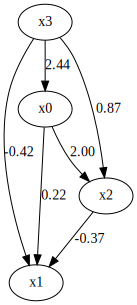

In [5]:
make_dot(B_s[0])

# Multi Group DirectLiNGAM

In [6]:
# perform Multi Group DirectLiNGAM
model = lingam.MultiGroupDirectLiNGAM()
model.fit(X)

In [7]:
# causal order P
order_estimate = model.causal_order_
P_estimate = np.eye(p)[order_estimate]

# causal effect matrices B
B_s_estimates = np.array(model.adjacency_matrices_)
B_estimates = P_estimate @ B_s_estimates @ P_estimate.T

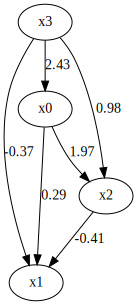

In [8]:
make_dot(B_s_estimates[0])

# errors

In [9]:
# errors
W_estimates = P_estimate.T @ (np.eye(p) - B_estimates) @ P_estimate
amari = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_estimates, A)])
error_P = 1 - (P_estimate == P).all()
error_B = np.mean((B_estimates - B) ** 2)

if error_P:
    print("The causal order P is not retrieved.")
else:
    print("The causal order P is retrieved!")
print(f"Error on causal effect matrices B : {error_B}")
print(f"Amari distance : {amari}")

The causal order P is retrieved!
Error on causal effect matrices B : 0.0005464143045726263
Amari distance : 0.0009351115416037781


# plot

In [10]:
# plot heat maps of causal effect matrices
def heat_maps_B(B, title_add=""):
    m = len(B)
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    if np.min(B) == np.max(B):
        print("B is equal to a constant.")
        return
    if np.min(B) < 0 and 0 < np.max(B):
        norm = TwoSlopeNorm(vmin=np.min(B), vmax=np.max(B), vcenter=0)
    else:
        norm = TwoSlopeNorm(vmin=np.min(B), vmax=np.max(B), vcenter=(np.min(B)+np.max(B))/2)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(B[i], norm=norm, cmap="coolwarm")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0085, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    fig.suptitle(f"{title_add} causal effect matrices", fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.1)
    plt.show()

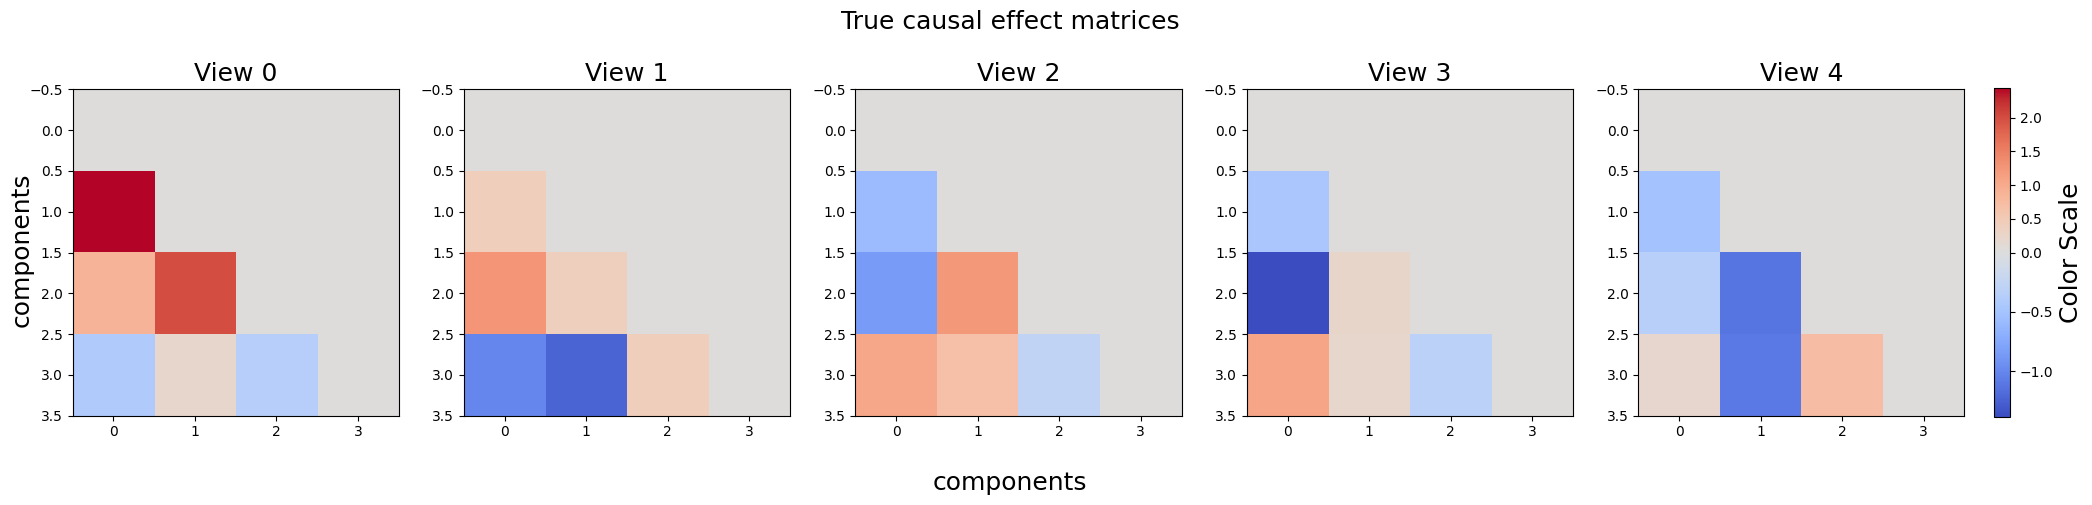

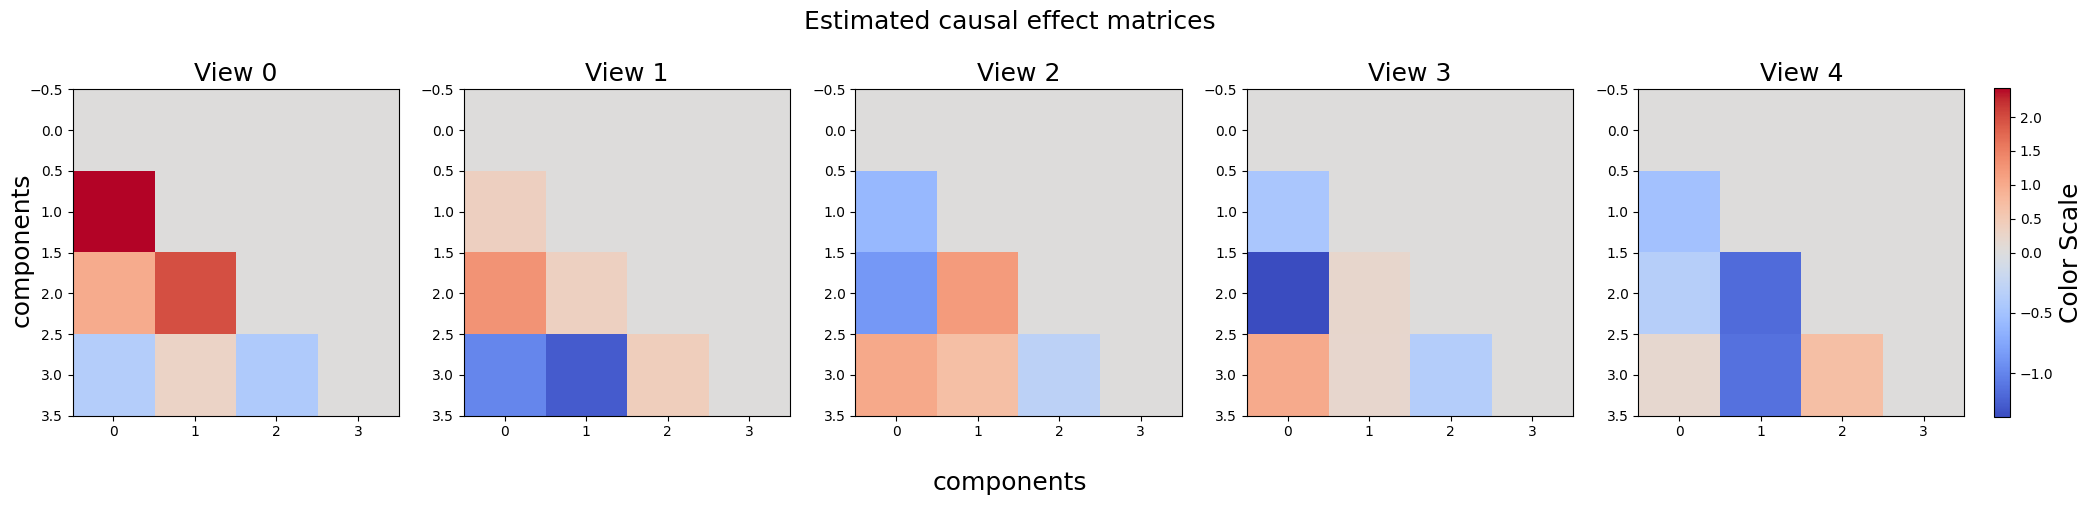

In [11]:
heat_maps_B(B, title_add="True")
heat_maps_B(B_estimates, title_add="Estimated")